In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scienceplots
import matplotlib.animation as animation
import project

In [2]:
#General parameters for matplotlib, which are: use sciendeplot style, the figure size, and set grid on by default
plt.style.use('science')
plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams.update({"axes.grid" : True})

### 1 neuron HH test

This is the initial trace for the HH model with which we are going to fit all the rest of the models that we are going to use in this project. The equations bellow are the equations of the model, with the fragment in blue highlighting the common addition that represents the gap junction and chemical synapses between the neurons.

This experiment is made for only one neuron, with a constant injected intensity, and no gap junction or synapse.

$$     \left( \frac{dv}{dt} \right)_i = \frac{1}{C}\left[-g_{na}m^3h(V_i-E_{na} - g_kn^4(V_i - E_k) - g_l(V_i-E_l) + I_i  \right] $$
$$    + \frac{1}{C}\color{blue} \left[  -\kappa \sum_{i\neq j}^N (V_i-V_j) - s_{syn}(V_i-V_{rest})\right] $$
$$     \left( \frac{dm}{dt} \right)_i = \alpha_m(V_i,V_t) \cdot (1-m) - \beta_m(V_i,V_t) \cdot m $$
$$ \left( \frac{dn}{dt} \right)_i = \alpha_n(V_i,V_t) \cdot (1-n) - \beta_n(V_i,V_t) \cdot n $$
$$  \left( \frac{dh}{dt} \right)_i = \alpha_h(V_i,V_t) \cdot (1-h) - \beta_h(V_i,V_t) \cdot h $$

In [3]:
params_HH = project.utils.load_HH()
#Initial conditions & the intensity
v0 = -65 
n0 = 0
m0 = 0
h0 = 0
y0 = [v0,n0,m0,h0]
Isyn = np.zeros(([2 , 2 ]))

#variables related to the numerical integration of the problem
dt = 0.001
t_final = 300
I = np.zeros((int(t_final/dt),2))
I[:,0] = 2.5

data_HH, residue_HH, a = project.models.HH_Neuron_Pairs(dt,t_final,2,[v0,v0],[n0,n0],[m0,m0],[h0,h0],*params_HH,I,Isyn,0,1)

(0.0, 50.0)

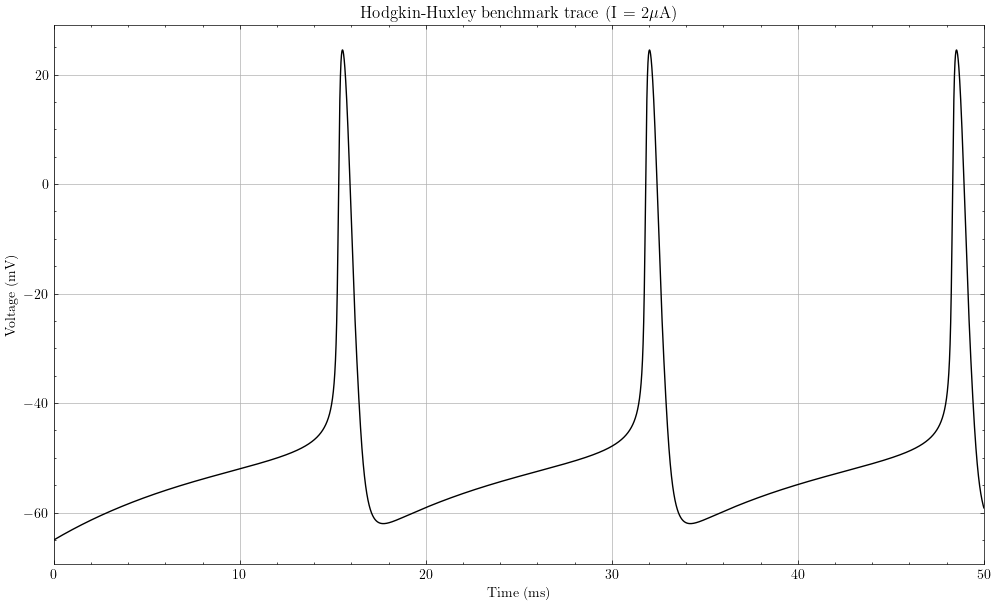

In [4]:
time = np.linspace(0,t_final,int(t_final/dt),)
plt.plot(time,data_HH[:,0], color = 'black')
plt.title(r'Hodgkin-Huxley benchmark trace (I = 2$\mu$A)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.xlim(0,50)

### Profiling with LIF

Now, we are going to start the profiling process. That is, tweak each of the models' parameters to match up with the trace shown in the Hh figure.

$$      \left( \frac{dv}{dt} \right)_i = \frac{1}{C} \left[ -g_l(V_i - E_l) + I_i \color{blue}  -\kappa \sum_{i\neq j}^N (V_i-V_j) - s_{syn}(V_i-V_{rest}) \color{white}\right] $$
$$     \text{if }  \ V_i \geq V_{th} \Rightarrow data_i \leftarrow w, \ V_i \leftarrow V_r $$


In [5]:
params_LIF = project.utils.load_LIF()
#Initial conditions & the intensity
Isyn = np.zeros(([2 , 2 ]))
I1 = np.zeros((int(t_final/dt),2))
I2 = np.zeros((int(t_final/dt),2))

for i in range(0,int(t_final/dt)):
    I1[i,0] = 2.5
    I2[i,0] = 0
#variables related to the numerical integration of the problem
dt = 0.001
t_final = 300
y0 = [-65, -65]

data2aIF, completeIF_2a, a = project.models.LIF_Neuron_Pairs(dt,t_final,2,y0,*params_LIF,I1,Isyn,0,1,1,0)

(0.0, 50.0)

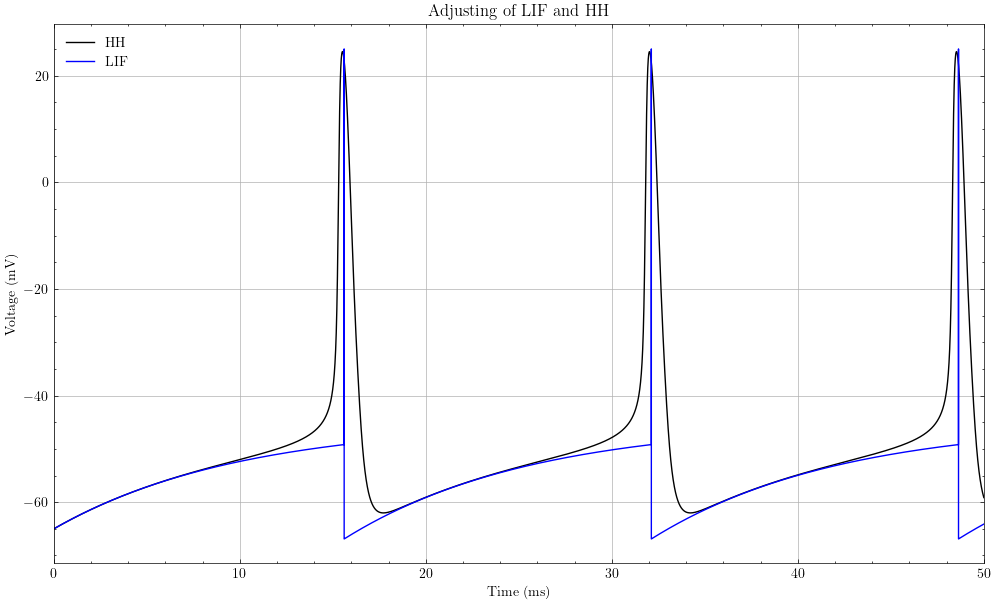

In [6]:
time = np.linspace(0,t_final,int(t_final/dt),)
plt.plot(time,data_HH[:,0], color = 'black', label = 'HH')
plt.plot(time,data2aIF[:,0], color = 'blue', label = 'LIF')
plt.title(r'Adjusting of LIF and HH')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.xlim(0,50)

### Profiling with Izhikevich

Same thing than with IF. Note that this traces are going to get more complicated, as these models are not as closely related to HH as LIF was. LIF was also adjusted before this work, so that's why we are not using **utils.load** for IZH and ML.

 $$ \left( \frac{dv}{dt} \right)_i = \frac{1}{C} \left[ k(V_i - V_r)(V_i - V_t) - u_i + I_i\right] $$
 $$     + \frac{1}{C}\color{blue} \left[  -\kappa \sum_{i\neq j}^N (V_i-V_j) - s_{syn}(V_i-V_{rest})\right] $$
 $$      \left( \frac{du}{dt} \right)_i = a \left[ b(V_i-V_r) - u_i \right] $$
 $$     \text{if } V_i \geq V_{peak}, \Rightarrow \ \ V_i \leftarrow c,  \ u_i \leftarrow u_i + d  $$

In [7]:
#The commented values are the original values that the literature had

C = 100 # 1
vr = -60 
vt = -40 # -75
k_ish = 1 / 15
a = 0.03 
b = -2
c = -50
d = 100 # 5e-6
vpeak = 35 # 25
k_u = 1

Isyn = [[0, 0.0], [0.0, 0]]
Is = np.array(Isyn)
tau = 1
dt = 0.001
t_final = 300
I1 = np.zeros((int(t_final/dt),2))
I2 = np.zeros((int(t_final/dt),2))

for i in range(0,int(t_final/dt)):
    I1[i,0] = 70
    I2[i,0] = 0
order = 2
y0 = [-65,-65]
u0 = [0.0,0.0]

data2Ish, completeIsh1, a = project.models.IZH_Neuron_Pairs(dt,t_final,order,y0,u0,I1,Is,C,vr,vt,k_ish,a,b,c,d,vpeak,k_u,0,tau)

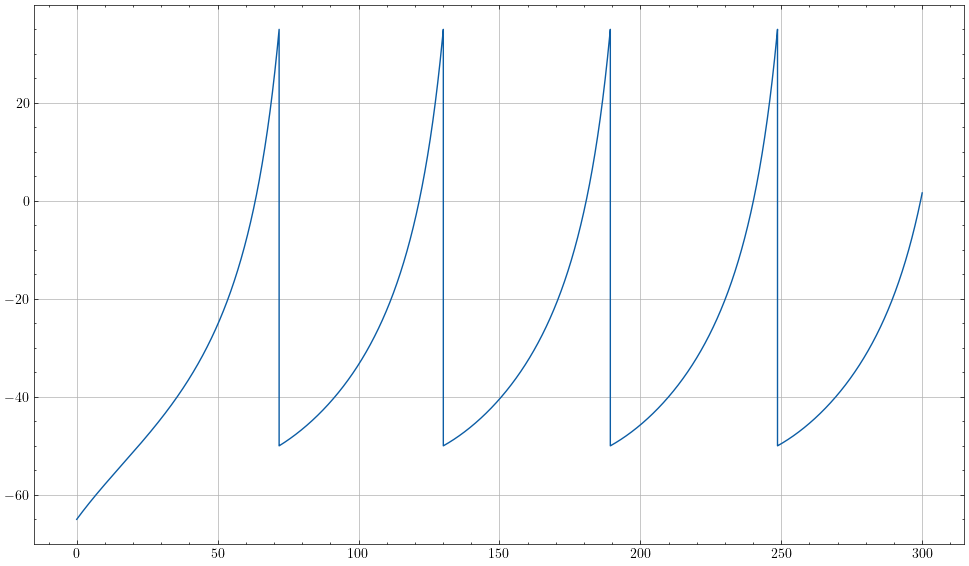

In [8]:
time = np.linspace(0,t_final,int(t_final/dt))
plt.plot(time,data2Ish[:,0])

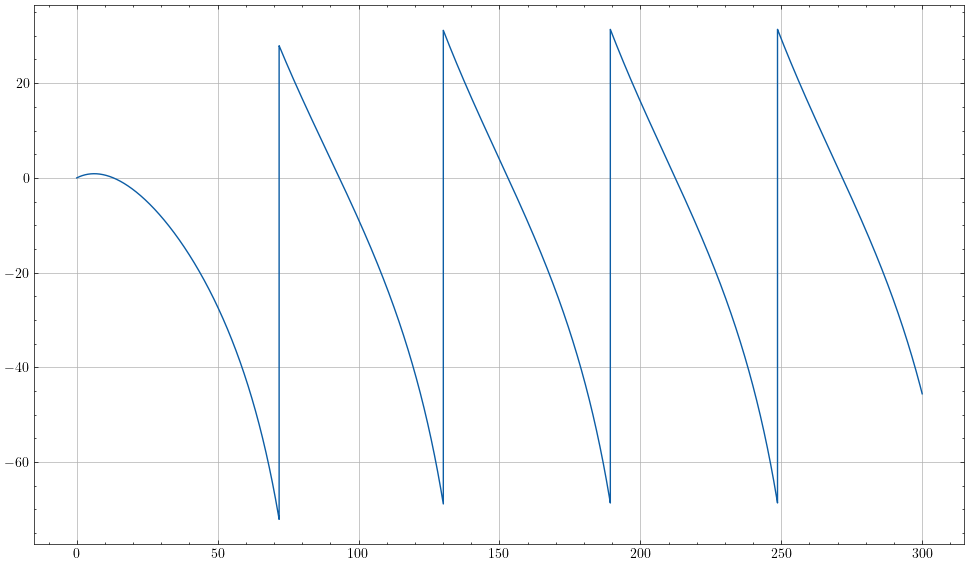

In [9]:
plt.plot(time,completeIsh1[:,1])

As part of our tries to fit a model, we tried looking at another form of the same model, simply known as The other Izhikevich model. This model was not used at the end, as the parameter conversion resulted in an inconvenience that was far greater than the advantages it could provide.

 $$ \left( \frac{dv}{dt} \right)_i = \frac{1}{\tau_v} \left[ (V_i - V_m)(V_i - V_{rb}) - k_uu_i + RI_i\right] $$
 $$     + \frac{1}{C}\color{blue} \left[  -\kappa \sum_{i\neq j}^N (V_i-V_j) - s_{syn}(V_i-V_{rest})\right] $$
 $$      \left( \frac{du}{dt} \right)_i = \frac{1}{\tau_u} \left[ a(V_i-V_{rc}) - u_i \right] $$
 $$     \text{if } V_i \geq V_{thresholdFS}, \Rightarrow \ \ V_i \leftarrow v_{rest},  \ u_i \leftarrow u_i + b  $$

 


In [10]:
#Capacity
tau_v = 15 #to 55 ms
tau_u = 10 
R = 8
k_u = 10 
v_m = -75
v_rb = -60
v_rc = -64
v_reset = -47
v_thres = 25 
a = 1
b = 5 #pA

C = 1# 1
vr = -60 
vt = -75 # -75
k_ish = 1 / 15
a = 1 / 10 
b = 1
c = -47
d =  5
vpeak = 25 # 25
k_u = 10 / 15 


I_0 = 0.01 #pA
dt = 0.001
t_final = 300
Isyn = [[0, 0.0], [0.0, 0]]
Is = np.array(Isyn)
tau = 1

I1 = np.zeros((int(t_final/dt),2))
I2 = np.zeros((int(t_final/dt),2))

for i in range(0,int(t_final/dt)):
    I1[i,0] = I_0 * 1 / 15 / 10  
    I2[i,0] = 0
order = 2
y0 = [-65,-65]
u0 = [0.0,0.0]

data2Ish_model2, completeIsh1_model2, a = project.models.IZH_Neuron_Pairs(dt,t_final,order,y0,u0,I1,Is,C,vr,vt,k_ish,a,b,c,d,vpeak,k_u,0,tau)

(0.0, 300.0)

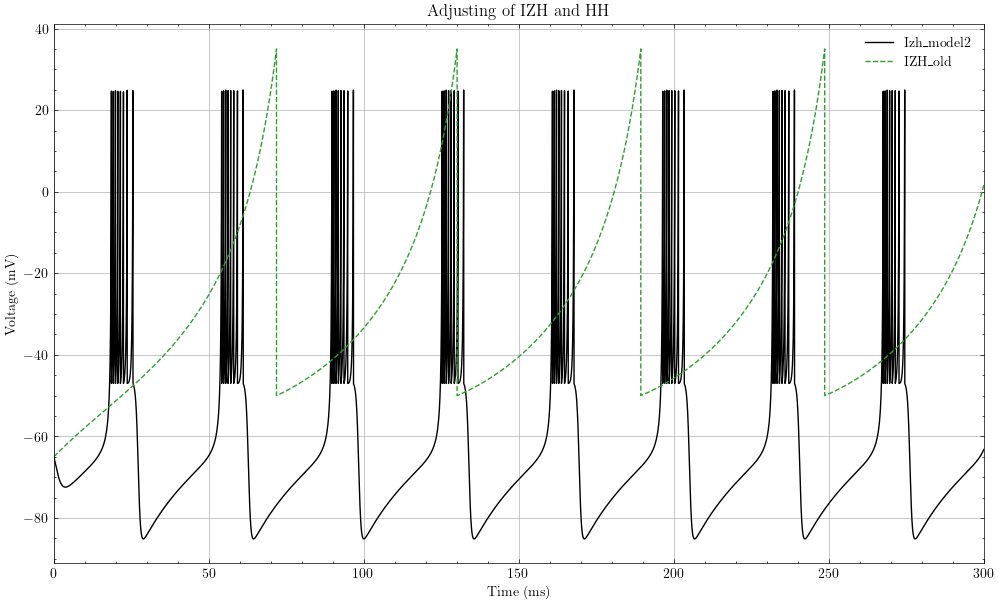

In [11]:
time = np.linspace(0,t_final,int(t_final/dt),)
plt.plot(time,data2Ish_model2[:,0], color = 'black', label = 'Izh_model2')
plt.plot(time,data2Ish[:,0], '--', color = 'tab:green', label = 'IZH_old')
plt.title(r'Adjusting of IZH and HH')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.xlim(0,300)

The previous plots were done to investigate the behaviour of the model, the following simulation contains the best result possible, after multiple experiments.

In [12]:
#Capacity
C = 1

#Resting and threshold potentials
vr = -70 #-70
vt = -48.5
k_2 = 0.0
k_u = 0.06

k_ish = 0.019 #neuron's rheobase
c = -60 #-70#voltage reset value

a = 0.5 #recovery time constant
b = -1.3 #neuron's input resistance 
d = 100#total amount of outward minus inwards currents activating during the spike
vpeak = 25
dt = 0.001
t_final = 300
Isyn = [[0, 0.0], [0.0, 0]]
Is = np.array(Isyn)
tau = 1

I1 = np.zeros((int(t_final/dt),2))
I2 = np.zeros((int(t_final/dt),2))

for i in range(0,int(t_final/dt)):
    I1[i,0] = 2.5
    I2[i,0] = 0
order = 2
y0 = [-65,-65]
u0 = [0.0,0.0]

data2Ish_new, completeIsh1_new, a = project.models.IZH_Neuron_Pairs(dt,t_final,order,y0,u0,I1,Is,C,vr,vt,k_ish,a,b,c,d,vpeak,k_u,k_2,tau)

(0.0, 50.0)

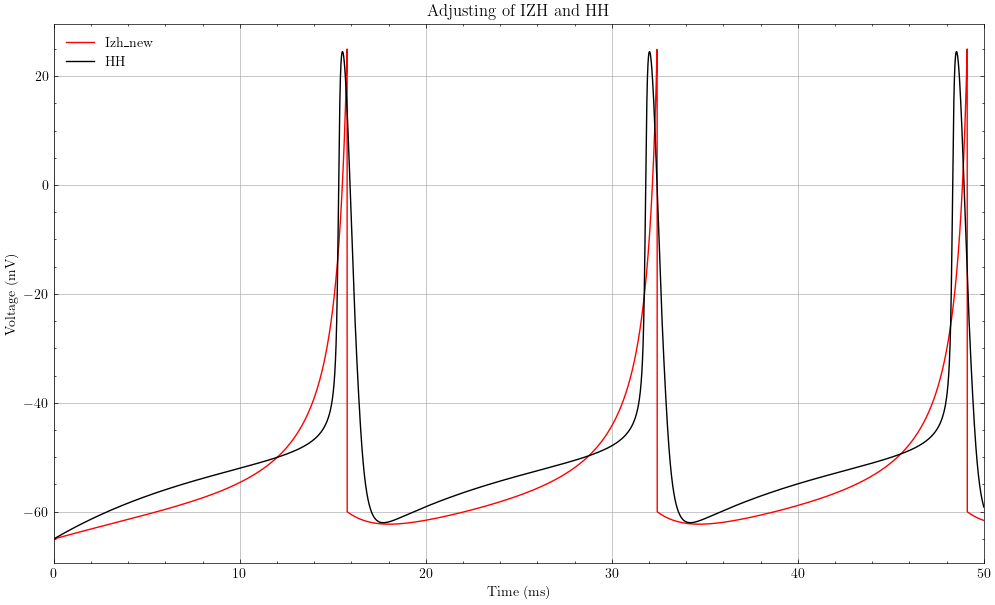

In [13]:
time = np.linspace(0,t_final,int(t_final/dt),)
plt.plot(time,data2Ish_new[:,0], color = 'red', label = 'Izh_new')
#plt.plot(time,data2Ish[:,0], color = 'tab:green', label = 'IZH_old')
plt.plot(time,data_HH[:,0], color = 'black', label = 'HH')

plt.title(r'Adjusting of IZH and HH')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.xlim(0,50)

(0.0, 50.0)

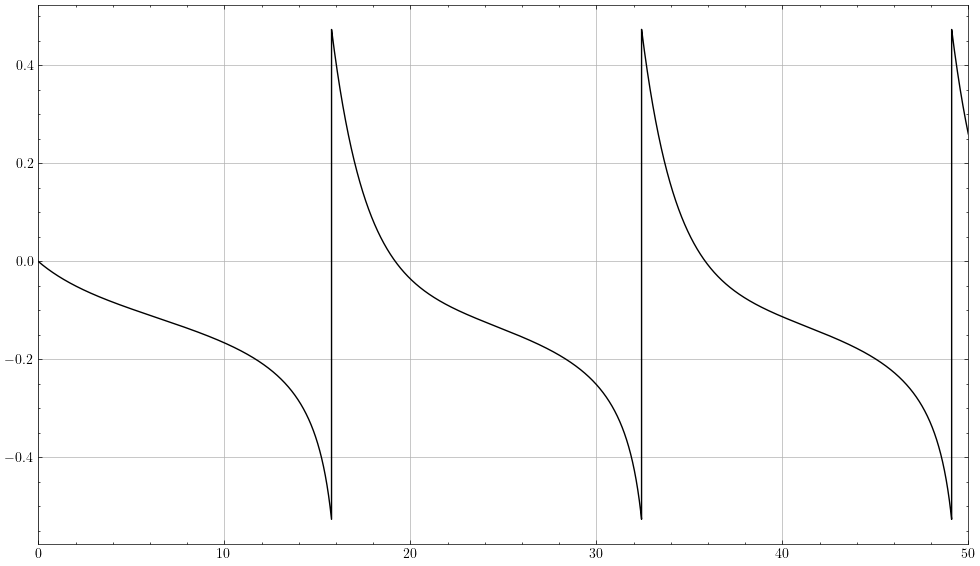

In [14]:
plt.plot(time,completeIsh1_new[:,1] / 100, color = 'black')
#plt.plot(time,completeIsh1[:,1]/100)
plt.xlim(0,50)

### Profiling with ML

The last of the four models, the Morris-Lecar. Same process than the other three
$$ \left( \frac{dv}{dt} \right)_i = \frac{1}{C} \left[ -I_{ion} -\kappa \sum_{i\neq j}^N (V_i-V_j)  + I_i \color{blue}   - s_{syn}(V_i-V_{rest}) \color{white}\right] $$
$$     I_{ion} (t) = g_{Na}m_{\infty}(V_{i})(V_i-E_{Na}) + g_kw(V_i)(V_i-E_k) + g_{shunt}(V_i-E_{shunt}) $$
$$      \left( \frac{dw}{dt} \right)_i = \varphi (w_{\infty}(V_i) - w_i)\cosh{\left(\frac{V_i - V_3}{2V_4}\right)} $$
$$     m_{\infty}(V_i) = \frac{1}{2}\left(1 + \tanh{\left(\frac{V_i-V_1}{V_2}\right)}\right) $$
$$     w_{\infty}(V_i) = \frac{1}{2}\left(1 + \tanh{\left(\frac{V_i-V_3}{V_4}\right)}\right)$$




Original trace, with the values obtained from the literature

In [15]:
Ena = 50 
Ek = -100 
Eshunt = -65
V1 = -1.2
V2 = 23
V3 = -2
V4 = 21
gna = 10
gk = 10
gshunt = 1.2 
C = 1
psi = 0.15



k = 0.00
dt = 0.001
t_final = 300
Isyn = [[0, 0.0], [0.0, 0]]
Is = np.array(Isyn)
tau = 1

I1 = np.zeros((int(t_final/dt),2))
I2 = np.zeros((int(t_final/dt),2))

for i in range(0,int(t_final/dt)):
    I1[i,0] = 18
    I2[i,0] = 0
order = 2
y0 = [-65 , -65]
w0 = [0.00, 0.00]

data2aML, completeML, a = project.models.ML_Neuron_Pairs(dt,t_final,2,y0,w0,psi,V1,V2,V3,V4,gna,gk,gshunt,Ena,Ek,Eshunt,C,I1,Is,k,tau)

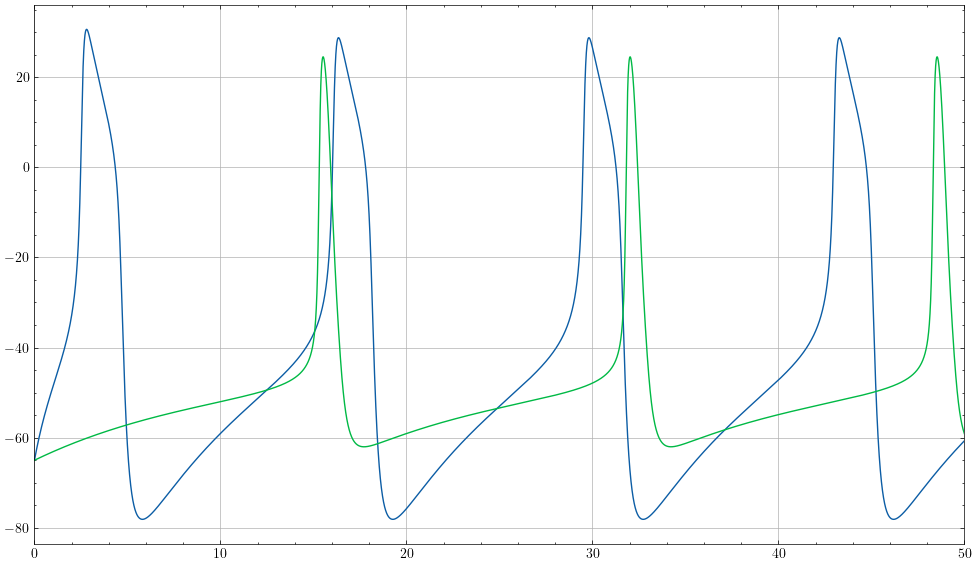

In [16]:
time = np.linspace(0,t_final,int(t_final/dt),)

plt.xlim(0,50)
plt.plot(time,data2aML[:,0])
plt.plot(time,data_HH[:,0])

Below we plot the evolution of the recovery variables of the model, in order to have a better chance to match both of these models (by matching their recovery values aswell)

In [17]:
def mg(v):
    v1 = 1.2
    V2 = 23
    return 0.5 * (1 + np.tanh( (v-v1) /V2 )) * gna

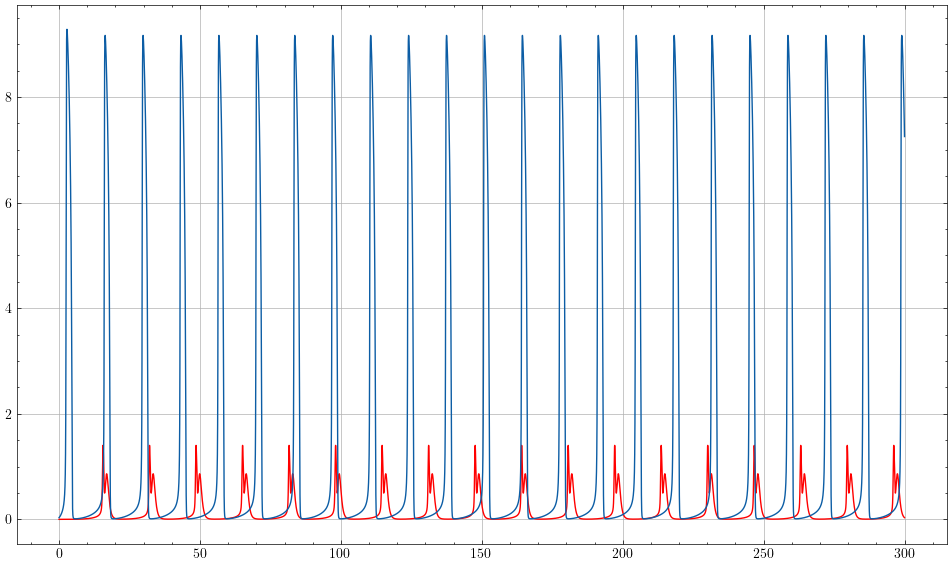

In [18]:
plt.plot(time,residue_HH[:,1]**3 * residue_HH[:,3] * 30, color = 'red')
plt.plot(time,mg(data2aML[:,0]))

We now present the best obtained value after trial and error, together with the corresponding values of the model

In [19]:
Ena = 90
Ek = -110
Eshunt = -75

V1 = -3
V2 = 20
V3 = -3
V4 = 19


gna = 2 # 1.39
gk = 2 #1.39
gshunt = 0.085#1/6 

C = 1
psi = 0.93



k = 0.00
dt = 0.001
t_final = 300
Isyn = [[0, 0.0], [0.0, 0]]
Is = np.array(Isyn)
tau = 1

I1 = np.zeros((int(t_final/dt),2))
I2 = np.zeros((int(t_final/dt),2))

for i in range(0,int(t_final/dt)):
    I1[i,0] = 2.5
    I2[i,0] = 0
order = 2
y0 = [-65 , -65]
w0 = [0.00, 0.00]

data2aML, completeML, a = project.models.ML_Neuron_Pairs(dt,t_final,2,y0,w0,psi,V1,V2,V3,V4,gna,gk,gshunt,Ena,Ek,Eshunt,C,I1,Is,k,tau)

(0.0, 50.0)

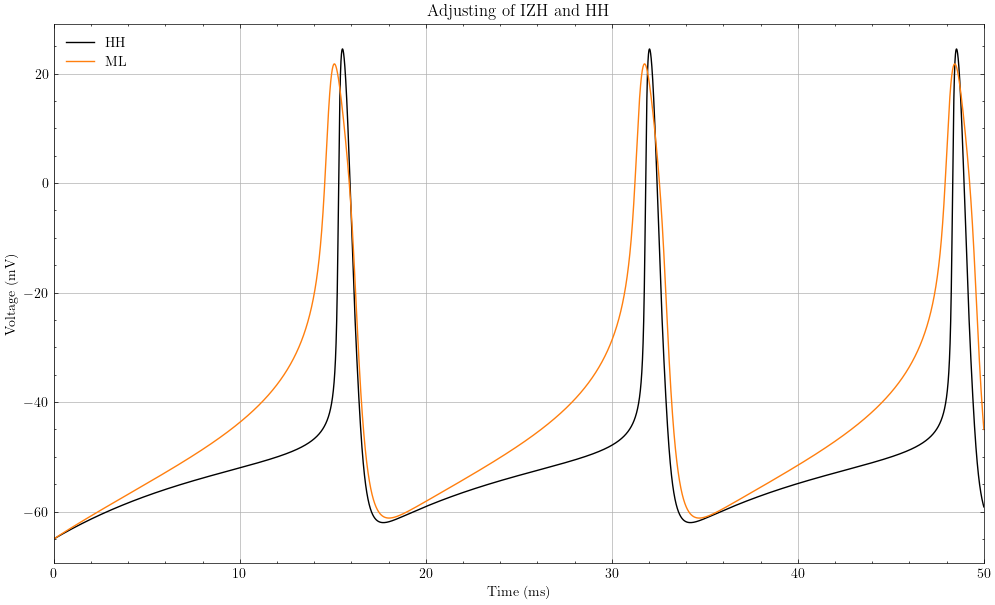

In [20]:
time = np.linspace(0,t_final,int(t_final/dt),)
plt.plot(time,data_HH[:,0], color = 'black', label = 'HH')
plt.plot(time,data2aML[:,0], color = 'tab:orange', label = 'ML')
plt.title(r'Adjusting of IZH and HH')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.xlim(0,50)

In [21]:
def mg(v):
    v1 = 1.2
    V2 = 23
    return 0.5 * (1 + np.tanh( (v-v1) /V2 )) * gna

(0.0, 50.0)

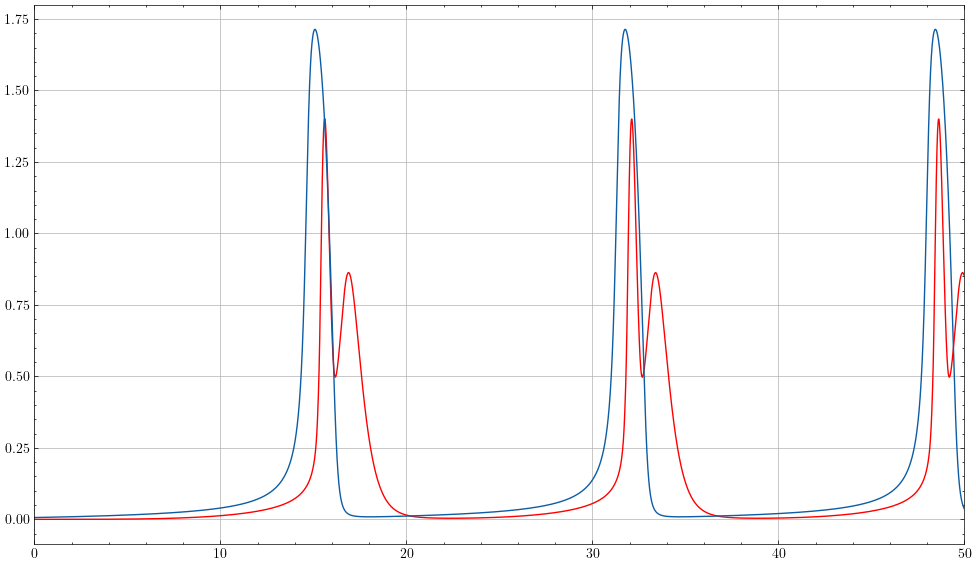

In [22]:
plt.plot(time,residue_HH[:,1]**3 * residue_HH[:,3] * 30, color = 'red')
plt.plot(time,mg(data2aML[:,0]))
plt.xlim(0,50)

(0.0, 50.0)

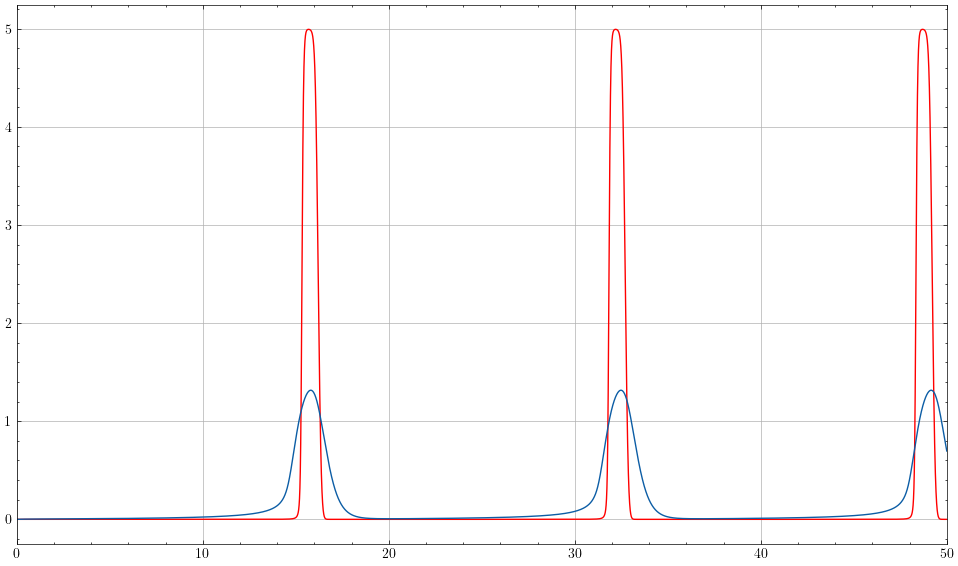

In [23]:
plt.plot(time,residue_HH[:,2]**4 * 5, color = 'red')
plt.plot(time,completeML[:,1]*gk)
plt.xlim(0,50)